# Improved interpretability for computer-aided severity assesment of Rethinopathy of Prematurity 
paper to appear as oral presentation at SPIE2019 Medical Imaging, Computer-aided diagnosis track 

In [3]:
%matplotlib inline
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import h5py
import sys
sys.path.append('./iMIMIC-RCVs/')
sys.path.append('./iMIMIC-RCVs/rcv_utils.py')
sys.path.append('./iMIMIC-RCVs/scripts/keras_vis_rcv/')
sys.path.append('./iMIMIC-RCVs/scripts/keras_vis_rcv/vis/')

import rcv_utils
import keras
import keras.backend as K
import sklearn.model_selection
import sklearn.linear_model
from rop_utils import *
PWD=''

/home/mara/venv/local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### 1. Loading concept measures from handcrafted features, for each image in the dataset

In [13]:
#feat = pd.read_csv('./sample_5kFeatures.csv')
feat = pd.read_csv('../5kFeatures.csv')
feature_names = feat.columns
feat['Image Name'] = feat['Image Name'].astype(str).str[:-4]
feat=feat.set_index('Image Name')
concepts = ['cti median', 'cti mean', 'curvature median', 'curvature mean', 'Avg segment diameter median', 'Avg point diameter mean']

In [14]:
meas = feat.to_dict('index')
# checking that the features have been successfully loaded
concept_measure = 'cti median'
image_file = 'BEAU-0071_000387_2_Posterior_os_No'
print  '{} measure for input file {} = '.format(concept_measure, image_file), meas[image_file][concept_measure]

cti median measure for input file BEAU-0071_000387_2_Posterior_os_No =  1.023713797


### 2. Loading ROP data

In [6]:
# Note: we cannot share the original images. 
# For more information you can contact me at: 
# mara.graziani@hevs.ch

h5file = '../split0.data/train.h5'
images, labels, original_files, classes = load_rop_data(h5file)
test_images, test_labels, test_original_files, test_classes = load_rop_data('../split0.data/test.h5')
inputs=np.array([swap(sample) for sample in images[:]])
print inputs.shape
test_inputs = np.array([swap(sample) for sample in test_images[:]])
print test_inputs.shape

data
labels
original_files
data
labels
original_files
(3264, 224, 224, 3)
(988, 224, 224, 3)


### 3. Loading the model

In [7]:
# Note: we cannot share the model weights. 
# For more information you can contact me at: 
# mara.graziani@hevs.ch

model = keras.models.load_model('../split0/final_model.h5')
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
Conv2d_1a_7x7_conv (Conv2D)     (None, 112, 112, 64) 9408        input_1[0][0]                    
__________________________________________________________________________________________________
Conv2d_1a_7x7_bn (BatchNormaliz (None, 112, 112, 64) 192         Conv2d_1a_7x7_conv[0][0]         
__________________________________________________________________________________________________
Conv2d_1a_7x7_act (Activation)  (None, 112, 112, 64) 0           Conv2d_1a_7x7_bn[0][0]           
__________________________________________________________________________________________________
MaxPool_2a

In [8]:
model.load_weights('../split0/best_weights.h5')

### 4. Computing the RCVs
For more information about the method you can read the paper
on regression concept vectors for bidirectional explanations
(https://github.com/medgift/iMIMIC-RCVs).

In [10]:
layers = ['Conv2d_2b_1x1_conv', 
          'Conv2d_2c_3x3_conv', 
          'Mixed_3b_Concatenated', 
          'Mixed_3c_Concatenated',
          'Mixed_4b_Concatenated',
          'Mixed_4c_Concatenated',
          'Mixed_5c_Concatenated'] 
max_rep = 3
batch_size=32
for repetition in range(0, 1):
    for l in layers[:]:
        feats=[]
        i=0
        if os.path.isfile('../rcv/phis/'+str(repetition)+'_concepts_phis_'+l+'.npy'):
            print '../rcv/phis/'+str(repetition)+'_concepts_phis_'+l+' already esists'
            continue
        get_layer_output = K.function([model.layers[0].input],
                                  [model.get_layer(l).output])
        while i+batch_size<len(inputs):
            feats.append(get_layer_output([inputs[i:i+batch_size]]))
            i+=batch_size
        feats.append(get_layer_output([inputs[i:]]))
        feats=np.array(feats)
        feats=feats.reshape((feats.shape[0]*feats.shape[1]*feats.shape[2], feats.shape[3], feats.shape[4], feats.shape[5]))
        np.save('../rcv/phis/'+str(repetition)+'_concepts_phis_'+l, np.asarray(feats))

../rcv/phis/0_concepts_phis_Conv2d_2b_1x1_conv already esists
../rcv/phis/0_concepts_phis_Conv2d_2c_3x3_conv already esists
../rcv/phis/0_concepts_phis_Mixed_3b_Concatenated already esists
../rcv/phis/0_concepts_phis_Mixed_3c_Concatenated already esists
../rcv/phis/0_concepts_phis_Mixed_4b_Concatenated already esists
../rcv/phis/0_concepts_phis_Mixed_4c_Concatenated already esists
../rcv/phis/0_concepts_phis_Mixed_5c_Concatenated already esists


In [15]:
l = layer = layers[-2]
repetition=0
rop_class = 'Plus'
rcvs = {}
acts = np.load('../rcv/phis/'+str(repetition)+'_concepts_phis_'+l+'.npy')
l=layer = layers[-1]
repetition=0
print layers
rop_class = 'Plus'
rcvs = {}
print 'Extracting RCV at layer: ', layer
acts = np.load('../rcv/phis/'+str(repetition)+'_concepts_phis_'+l+'.npy')
for c in concepts[:1]:
    if c not in rcvs.keys():
        rcvs[c]={}
    print 'Analysing concept: ', c
    fvec=[]
    to_keep=[]
    classes=[]
    fvec, to_keep = get_concept_measures_vector(meas, original_files, c)
    print acts.shape
    X=(np.asarray([acts[i].ravel() for i in to_keep], dtype=np.float64))  
    print X.shape
    classes = [get_sample_class(labels, i) for i in to_keep]
    idxs = get_class_indices(classes, rop_class)
    print idxs
    print X[idxs].shape
    reg_score, cv = solve_regression(
                np.squeeze(X[idxs], axis=1), 
                np.squeeze(fvec[idxs], axis=1), 
                random_state=repetition
    )
    print 'Regression output: ', reg_score, ' (', rop_class, ')'
    rcvs[c][rop_class] = cv

['Conv2d_2b_1x1_conv', 'Conv2d_2c_3x3_conv', 'Mixed_3b_Concatenated', 'Mixed_3c_Concatenated', 'Mixed_4b_Concatenated', 'Mixed_4c_Concatenated', 'Mixed_5c_Concatenated']
Extracting RCV at layer:  Mixed_5c_Concatenated
Analysing concept:  cti median
(3264, 7, 7, 1024)
(3238, 50176)
[[2158]
 [2159]
 [2160]
 ...
 [3235]
 [3236]
 [3237]]
(1080, 1, 50176)
N.  0 ..
720
0.5435025503141853
N.  1 ..
720
0.45235606547785745
N.  2 ..
720
0.5343546518571483
0.510071089216397
angle:  0.9955726934551511
angle:  0.992904898020826
Regression output:  0.510071089216397  ( Plus )


In [25]:
regression_outputs = compute_regression(max_rep, layers[2:], meas, original_files, acts, labels, concepts)

Layer:  Mixed_3b_Concatenated
(3264, 28, 28, 256)
N.  0 ..
716
0.05323439828445953
N.  1 ..
716
-7.720960726701713e+19
N.  2 ..
716
-6.416333465403717e+18
-2.7875313577473618e+19
angle:  1.573347931489505
angle:  1.5854454860461016
N.  0 ..
722
-0.1294199935423268
N.  1 ..
723
0.07953982390907044
N.  2 ..
723
0.014574745651271039
-0.011768474660661776
angle:  1.4629636718677606
angle:  1.1570383059683367
N.  0 ..
720
0.4511238930787894
N.  1 ..
720
0.38392455239973755
N.  2 ..
720
0.3871862733989403
0.4074115729591557
angle:  1.1852784181512295
angle:  1.393929948324339
cti median : 
images with concept measures:  3238
Normal:  1084 Pre-plus:  1074 Plus:  1080
regression output:  -0.011768474660661776  (normal) -2.7875313577473618e+19  (preplus) 0.4074115729591557 (plus)
N.  0 ..
716
-0.03178295885796367
N.  1 ..
716
-2.5751149197230965e+19
N.  2 ..
716
-3.92157645807569e+19
-2.1655637925995954e+19
angle:  1.5729263392355293
angle:  1.5854454860461142
N.  0 ..
722
-0.019381513551202545

716
-1.2479666731488109e+19
N.  2 ..
716
-3.4579065629800934e+17
-4.2751524625953725e+18
angle:  1.5721743244148232
angle:  1.5596295336483152
N.  0 ..
722
0.5460441323845122
N.  1 ..
723
0.5241966426807803
N.  2 ..
723
0.46686444359138457
0.5123684062188923
angle:  0.9340778105999691
angle:  0.9754153735433265
N.  0 ..
720
0.5247558456788465
N.  1 ..
720
0.5211712740942003
N.  2 ..
720
0.4733128544810614
0.5064133247513695
angle:  0.8991922150640992
angle:  0.9419971205145883
Avg point diameter mean : 
images with concept measures:  3238
Normal:  1084 Pre-plus:  1074 Plus:  1080
regression output:  0.5123684062188923  (normal) -4.2751524625953725e+18  (preplus) 0.5064133247513695 (plus)
Layer:  Mixed_4b_Concatenated
(3264, 14, 14, 512)
N.  0 ..
716
0.19919063000489068
N.  1 ..
716
-1.9387366501757436e+20
N.  2 ..
716
-1.766834251817993e+20
-1.2351903006645787e+20
angle:  1.5762425748903555
angle:  1.57768211919725
N.  0 ..
722
0.1416545962650878
N.  1 ..
723
0.19165756644711474
N.  2 

N.  0 ..
722
0.3780679628374851
N.  1 ..
723
0.39053860769193094
N.  2 ..
723
0.3470690234583113
0.3718918646625758
angle:  1.0029615303036847
angle:  0.915922988863698
N.  0 ..
720
0.5511675247675556
N.  1 ..
720
0.5776020464503357
N.  2 ..
720
0.5715523584818812
0.5667739765665908
angle:  0.9577551333304561
angle:  0.9905352695625897
Avg segment diameter median : 
images with concept measures:  3238
Normal:  1084 Pre-plus:  1074 Plus:  1080
regression output:  0.3718918646625758  (normal) -3.235957609508551e+19  (preplus) 0.5667739765665908 (plus)
N.  0 ..
716
0.5609485830973977
N.  1 ..
716
-2121271731036.9927
N.  2 ..
716
-9.092789564360044e+17
-3.030936925692451e+17
angle:  1.5706337384855515
angle:  1.5739432568395075
N.  0 ..
722
0.5828185500175367
N.  1 ..
723
0.5388837406369911
N.  2 ..
723
0.5215900359460552
0.547764108866861
angle:  0.9000861237409623
angle:  0.9254578406042425
N.  0 ..
720
0.5901355721657735
N.  1 ..
720
0.5988702131871706
N.  2 ..
720
0.5769425112399253
0.

723
0.11232090919674133
0.13007684665448396
angle:  1.0322120138103639
angle:  0.9245015134208032
N.  0 ..
720
0.4439551866479272
N.  1 ..
720
0.4445721914709446
N.  2 ..
720
0.368050498842005
0.4188592923202923
angle:  0.9065862121851748
angle:  1.0299202198463404
curvature mean : 
images with concept measures:  3238
Normal:  1084 Pre-plus:  1074 Plus:  1080
regression output:  0.13007684665448396  (normal) -1.8499325787454144e+18  (preplus) 0.4188592923202923 (plus)
N.  0 ..
716
0.375698660709719
N.  1 ..
716
-1.0337544842612056e+20
N.  2 ..
716
-5.1532895164521234e+19
-5.163611453021393e+19
angle:  1.5707763142623279
angle:  1.5561471675436271
N.  0 ..
722
0.3750581458605644
N.  1 ..
723
0.27753985075728593
N.  2 ..
723
0.28086102716947015
0.31115300792910683
angle:  1.0377558529488555
angle:  0.9769641766704373
N.  0 ..
720
0.43267087247889746
N.  1 ..
720
0.4660182935433017
N.  2 ..
720
0.4492642566835727
0.44931780756859063
angle:  0.9636659085616457
angle:  1.0079196281603173
Av

N.  0 ..
720
0.6920463009414591
N.  1 ..
720
0.6793412915752741
N.  2 ..
720
0.6719403217916057
0.6811093047694463
angle:  0.8355727061873817
angle:  0.8366261823070336
curvature median : 
images with concept measures:  3238
Normal:  1084 Pre-plus:  1074 Plus:  1080
regression output:  0.47803807590846786  (normal) -6.72897177450052e+18  (preplus) 0.6811093047694463 (plus)
N.  0 ..
716
0.4359998198879949
N.  1 ..
716
-1.3334865651318845e+19
N.  2 ..
716
-6.587486711418661e+18
-6.640784120912503e+18
angle:  1.57054080439772
angle:  1.563910534392508
N.  0 ..
722
0.31933531907848656
N.  1 ..
723
0.33679192544865677
N.  2 ..
723
0.3362857011824607
0.3308043152365347
angle:  1.0200022911854512
angle:  0.8886875897721992
N.  0 ..
720
0.5516280850720747
N.  1 ..
720
0.5843578510233621
N.  2 ..
720
0.5224546687142168
0.5528135349365512
angle:  0.877269045445607
angle:  0.9554439897479149
curvature mean : 
images with concept measures:  3238
Normal:  1084 Pre-plus:  1074 Plus:  1080
regression

N.  0 ..
716
0.4656892575166951
N.  1 ..
716
-1.2694112832515968e+16
N.  2 ..
716
-1.4998711288453608e+16
-9230941373656526.0
angle:  1.5734909071819345
angle:  1.5697784836531412
N.  0 ..
722
0.4870846534406298
N.  1 ..
723
0.4295221408434402
N.  2 ..
723
0.4733975520378392
0.46333478210730306
angle:  0.9480597704565041
angle:  1.0402603730030544
N.  0 ..
720
0.7473025997770628
N.  1 ..
720
0.6921405345388213
N.  2 ..
720
0.7035574204258442
0.7143335182472428
angle:  0.8125136254698799
angle:  0.856220581959108
curvature median : 
images with concept measures:  3238
Normal:  1084 Pre-plus:  1074 Plus:  1080
regression output:  0.46333478210730306  (normal) -9230941373656526.0  (preplus) 0.7143335182472428 (plus)
N.  0 ..
716
0.3568251924020781
N.  1 ..
716
-5.543331349429968e+16
N.  2 ..
716
-5766784453650119.0
-2.04000326493166e+16
angle:  1.5684671039035645
angle:  1.5697784836531519
N.  0 ..
722
0.28715741045521026
N.  1 ..
723
0.30937129239347183
N.  2 ..
723
0.3995994897558474
0.

716
-1.2187311667538334e+19
N.  2 ..
716
-2.809417604682926e+19
-1.3427162571455865e+19
angle:  1.5731707284221679
angle:  1.5596295336484074
N.  0 ..
722
0.03908370158329577
N.  1 ..
723
-0.02653167464121387
N.  2 ..
723
-0.01927686084113267
-0.0022416112996835893
angle:  1.414798029345432
angle:  1.238753599155095
N.  0 ..
720
0.28424822273079386
N.  1 ..
720
0.20543655586458165
N.  2 ..
720
0.2671089106573675
0.25226456308424766
angle:  1.2631543137686527
angle:  1.1567443472927084
cti mean : 
images with concept measures:  3238
Normal:  1084 Pre-plus:  1074 Plus:  1080
regression output:  -0.0022416112996835893  (normal) -1.3427162571455865e+19  (preplus) 0.25226456308424766 (plus)
N.  0 ..
716
0.4544444317920625
N.  1 ..
716
-5.755512276430819e+17
N.  2 ..
716
-4.457452351073779e+17
-3.404321542501533e+17
angle:  1.5707356614678722
angle:  1.5819631199412316
N.  0 ..
722
0.39520350957873307
N.  1 ..
723
0.34204043151332464
N.  2 ..
723
0.3327411908843141
0.3566617106587906
angle: 

N.  0 ..
722
0.09194248766231516
N.  1 ..
723
0.15455817458016663
N.  2 ..
723
0.11731254880887476
0.12127107035045219
angle:  1.0777210929028442
angle:  1.0548406303156244
N.  0 ..
720
0.5466166897986875
N.  1 ..
720
0.5341013969499058
N.  2 ..
720
0.4923435806162541
0.5243538891216158
angle:  1.0886254988755115
angle:  1.420684032523095
cti median : 
images with concept measures:  3238
Normal:  1084 Pre-plus:  1074 Plus:  1080
regression output:  0.12127107035045219  (normal) -4.0290753946802176e+18  (preplus) 0.5243538891216158 (plus)
N.  0 ..
716
0.10027279290779656
N.  1 ..
716
-2071577683776.8538
N.  2 ..
716
-7.387545791896682e+19
-2.4625153330181505e+19
angle:  1.5687306199330584
angle:  1.5739432566288476
N.  0 ..
722
0.03862259291797354
N.  1 ..
723
-0.020335651164078206
N.  2 ..
723
-0.01914080694247078
-0.0002846217295251474
angle:  1.0699594411356057
angle:  1.057502196552971
N.  0 ..
720
0.43850798549990644
N.  1 ..
720
0.3853724827467401
N.  2 ..
720
0.40625826196177783


720
0.6509033606027396
N.  1 ..
720
0.577159910269989
N.  2 ..
720
0.5764120787323472
0.6014917832016919
angle:  0.8774881208507814
angle:  0.9306837610003617
Avg point diameter mean : 
images with concept measures:  3238
Normal:  1084 Pre-plus:  1074 Plus:  1080
regression output:  0.5249568767331599  (normal) -9.562719790142035e+16  (preplus) 0.6014917832016919 (plus)


In [27]:
try:
    os.path.exists('./results')
except:
    os.mkdir('./results')
np.save('./results/preliminary_regression_outputs_def', regression_outputs)

In [31]:
regression_outputs.keys()

['Mixed_4b_Concatenated',
 'Mixed_3b_Concatenated',
 'Mixed_5c_Concatenated',
 'Mixed_3c_Concatenated',
 'Mixed_4c_Concatenated']

In [34]:
layers[2:]

['Mixed_3b_Concatenated',
 'Mixed_3c_Concatenated',
 'Mixed_4b_Concatenated',
 'Mixed_4c_Concatenated',
 'Mixed_5c_Concatenated']

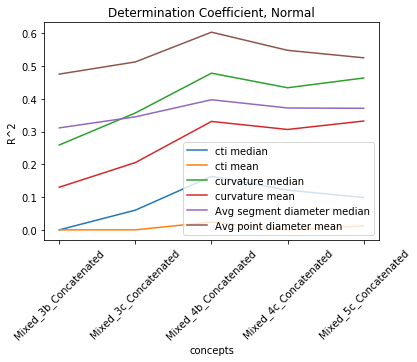

In [35]:
plot_dynamics(regression_outputs, 'Normal', concepts, layers[2:])

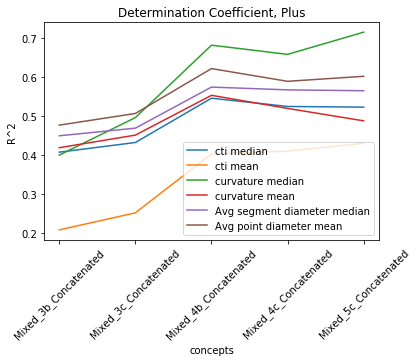

In [36]:
plot_dynamics(regression_outputs, 'Plus', concepts, layers[2:])